In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

from gbi.GBI import GBInference
from gbi.distances import mse_dist
import gbi.hh.utils as utils

/home/michael/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("data/theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("data/summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

In [4]:
nsims = 100_000

In [5]:
theta = theta[:nsims]
x = x[:nsims]

In [6]:
n_nonaug_x = nsims
n_augmented_x = nsims
noise_level = 2.0

In [7]:
x_aug = x[torch.randint(x.shape[0], size=(n_augmented_x,))]
x_aug = x_aug + torch.randn(x_aug.shape) * x.std(dim=0) * noise_level
x_target = torch.cat([x[:n_nonaug_x], x_aug])

In [20]:
true_params, labels_params = utils.obs_params(reduced_model=False)

prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)

In [29]:
inference = GBInference(prior, mse_dist, do_precompute_distances=False)

In [30]:
inference = inference.append_simulations(theta, x, x_target)

In [31]:
inference.initialize_distance_estimator(
    3, 
    50, 
    positive_constraint_fn="relu",
    net_kwargs={
        "z_score_theta": True,
        "z_score_x": True,
        "z_score_dists": True,
    }
)

score!


In [32]:
distance_net = inference.train(
    training_batch_size=5_000,
    max_n_epochs=50,
    stop_after_counter_reaches=20,
    print_every_n=1,
    plot_losses=False,
)

0: train loss: 11928334336.000000, val loss: 12887667712.000000, 0.7905 seconds per epoch.
1: train loss: 7758052864.000000, val loss: 7719913472.000000, 0.7899 seconds per epoch.
2: train loss: 3222807040.000000, val loss: 3516105984.000000, 0.7821 seconds per epoch.
3: train loss: 2862745856.000000, val loss: 3164363776.000000, 0.8208 seconds per epoch.
4: train loss: 2766015232.000000, val loss: 2676595712.000000, 0.7972 seconds per epoch.
5: train loss: 2326179328.000000, val loss: 2650714624.000000, 0.7933 seconds per epoch.
6: train loss: 2571389952.000000, val loss: 2322112768.000000, 0.7963 seconds per epoch.
7: train loss: 2114278400.000000, val loss: 2424312832.000000, 0.7904 seconds per epoch.
8: train loss: 2112657280.000000, val loss: 2235979008.000000, 0.7873 seconds per epoch.
9: train loss: 1955136640.000000, val loss: 2035965440.000000, 0.7847 seconds per epoch.
10: train loss: 2089278464.000000, val loss: 1893696640.000000, 0.7944 seconds per epoch.
11: train loss: 18

In [33]:
inds1 = torch.randint(0, 1000, (100,))
inds2 = torch.randint(0, 1000, (100,))
pred_dists = distance_net.forward(theta[inds1], x_target[inds2]).detach()
true_dists = torch.mean((x[inds1] - x_target[inds2])**2, dim=1)

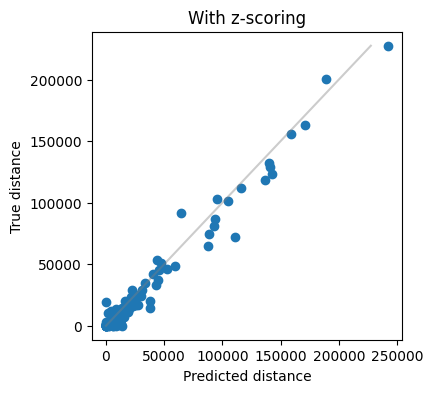

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_ = ax.scatter(pred_dists.numpy(), true_dists.numpy())
_ = ax.plot([0, np.max(true_dists.numpy())], [0, np.max(true_dists.numpy())], c="grey", alpha=0.4)
_ = ax.set_xlabel("Predicted distance")
_ = ax.set_ylabel("True distance")
ax.set_title("With z-scoring")
plt.savefig("z-score.png", dpi=200, bbox_inches="tight")